In [2]:
push!(LOAD_PATH, "../")
push!(LOAD_PATH, "../../src/")
push!(LOAD_PATH, "../periodicweyl/")
push!(LOAD_PATH, "../src/")

#module PWruns

using SparseArrays
#using PlotStuff
using LinearAlgebra
using PWHamiltonian
using Bands
using Constants
using UsefulFunctions
using Operators
using SLutils
#using DOS
using Arpack
using Plots
using PyPlot
using LaTeXStrings
using Optim
using Distributed

a = 10*Å

nx = 100; ny = 1; nz = 1;

#eV = 1;

function paramGen(nx::Int,ny::Int,nz::Int, gcut::Vector{Int}=[20;0;0], m::Float64=0.0*eV)
    a₁ = a*[nx;0;0]; a₂ = a*[0;ny;0]; a₃ = a*[0;0;nz]
    A = hcat(a₁,a₂,a₃)
    B = 2*π*transpose(inv(A))
    #nmax = 50;
    maxG = Int.(round.((4/a)*[maximum(a₁),maximum(a₂),maximum(a₃)])) # highest brillouin zone to sample to. Needs to be big enough to make program not crash.
    #sG = 2*maxG+1 # number of G points in PW grid
    #gcut = 1.5*eV 
    #gcut = [10;0;0]
    Gs, nG = gGrid(B,maxG,gcut) # truncated G grid for hamiltonian

    sG = (2*maxG[1]+1,2*maxG[2]+1,2*maxG[3]+1)
    #println("$Gs")
    params = (
           arpack = false, η = 0.0001*eV, μ_disorder=0.00001*eV, ng=nG, nG=nG, sG = sG, bandwidth=false,
           maxG=maxG, gcut = gcut, A = A, B = B, norb = 2, vf = 1.5*10^6, m = m, t = 1*eV
             )
    return params
end


function Htype(nx::Int,ny::Int,nz::Int, Mfield::String, gcut::Vector{Int}, β::Float64=0.25*eV, m::Float64=0.0*eV)
    p = paramGen(nx,ny,nz,gcut,m)
    V = zeros(ComplexF64,p.sG[1],p.sG[2],p.sG[3])
    Mx = zeros(ComplexF64,p.sG[1],p.sG[2],p.sG[3])
    My = zeros(ComplexF64,p.sG[1],p.sG[2],p.sG[3])
    Mz = zeros(ComplexF64,p.sG[1],p.sG[2],p.sG[3])
    if(Mfield == "sNeel")
        My[gridOffset(p,[1,0,0])] = β*1/2; My[gridOffset(p,[-1,0,0])] = β*1/2
        Mx[gridOffset(p,[1,0,0])] = β*im/2; Mx[gridOffset(p,[-1,0,0])] = -β*im/2
    elseif(Mfield=="sBloch")
        My[gridOffset(p,[1,0,0])] = β*1/2; My[gridOffset(p,[-1,0,0])] = β*1/2
        Mz[gridOffset(p,[1,0,0])] = β*im/2; Mz[gridOffset(p,[-1,0,0])] = -β*im/2
    elseif(Mfield=="consty")
        My[gridOffset(p,[0,0,0])] = β;
    end
    # generates the hamiltonian(k) function using the 
    # fourier grids of  [V, Mx, My, Mz] ⋅ [σ₀, σ₁, σ₂, σ₃]
    # to periodically apply the spin operators 
    return ConstructHamiltonian(p,[V,Mx,My,Mz]), p
end

p = paramGen(nx,ny,nz)

V = zeros(ComplexF64,p.sG[1],p.sG[2],p.sG[3])
Mx = zeros(ComplexF64,p.sG[1],p.sG[2],p.sG[3])
My = zeros(ComplexF64,p.sG[1],p.sG[2],p.sG[3])
Mz = zeros(ComplexF64,p.sG[1],p.sG[2],p.sG[3])


β = 0.25

My[gridOffset(p,[0,0,0])] = β*0;

#simple neel helix 
Mx[gridOffset(p,[1,0,0])] = β*1/2; Mx[gridOffset(p,[-1,0,0])] = β*1/2
My[gridOffset(p,[1,0,0])] = β*im/2; My[gridOffset(p,[-1,0,0])] = -β*im/2

#simplest neel lattice


#My[gridOffset(p,[1,0,0])] = β*1/2; My[gridOffset(p,[-1,0,0])] = β*1/2
#My[gridOffset(p,[3,0,0])] = -β*0.1/2; My[gridOffset(p,[-3,0,0])] = -β*0.1/2
#Mx[gridOffset(p,[1,0,0])] = β*im*0.6/2; Mx[gridOffset(p,[-1,0,0])] = -β*im*0.6/2
#Mx[gridOffset(p,[3,0,0])] = -β*im*0.2/2; Mx[gridOffset(p,[-3,0,0])] = β*im*0.2/2

# simple bloch helix 

V = zeros(ComplexF64,p.sG[1],p.sG[2],p.sG[3])
Mx = zeros(ComplexF64,p.sG[1],p.sG[2],p.sG[3])
My = zeros(ComplexF64,p.sG[1],p.sG[2],p.sG[3])
Mz = zeros(ComplexF64,p.sG[1],p.sG[2],p.sG[3])
My[gridOffset(p,[1,0,0])] = β/2; My[gridOffset(p,[-1,0,0])] = β*1/2
Mz[gridOffset(p,[1,0,0])] = β*im/2; Mz[gridOffset(p,[-1,0,0])] = -β*im/2


#simplest bloch lattice


#=
My[gridOffset(p,[1,0,0])] = β*1; My[gridOffset(p,[-1,0,0])] = β*1
My[gridOffset(p,[3,0,0])] = -β*0.1; My[gridOffset(p,[-3,0,0])] = -β*0.1
Mz[gridOffset(p,[1,0,0])] = β*im*0.6; Mz[gridOffset(p,[-1,0,0])] = -β*im*0.6
Mz[gridOffset(p,[3,0,0])] = -β*im*0.2; Mz[gridOffset(p,[-3,0,0])] = β*im*0.2
=#


#Mx[gridOffset(p,[1,0,0])] = 1/2; Mx[gridOffset(p,[-1,0,0])] = 1/2


Mx[gridOffset(p,[0,0,0])] = 0.00001; 
#Mz[gridOffset(p,[0,0,0])] = 1.0; 

#Mz[gridOffset(p,[-2,0,0])] = 1/2

function kdictGen(A, J::Float64=0.0, m::Float64=0.0, vf::Float64=1.5*10^6*ħ/q)
	B = transpose(2*π*inv(A))
	kdict = Dict(
		    "Γ" => B*[ 0  ;    0;   0],
		    "[1/nx,1,1](π/a₀)" => B*[ 1/2;  1/2; 1/2],
		    "[1/nx,1,0](π/a₀)" => B*[ 1/2;  1/2;   0],
		    "[0,0,1](π/a₀)" => B*[   0;    0; 1/2],
		    "[0,0,1](π/a₀)" => B*[  0;    0;-1/2],
		    "[0,1,0](π/a₀)" => B*[   0;    1/2; 0],
		    "[0,-1,0](π/a₀)" => B*[  0;  -1/2;0],
		    "[1/nx,0,0](π/a₀)" => B*[   1/2;    0; 0],
		    "[-1/nx,0,0](π/a₀)" => B*[  -1/2;    0;0],
		    "[0,0,1](π/a₀)" => B*[  0;    0;1/2], #
            "k₀" => [0; √(J^2-m^2)/vf; 0],
            "k₀+[1/nx,0,0](π/a₀)" => ([0; √(J^2-m^2)/vf; 0]+p.B*[   1/2;    0; 0]),
		    "Γ" => B*[ 0  ;    0;   0],
		    "A" => B*[ 1/2;  1/2; 1/2],
		    "M" => B*[ 1/2;  1/2;   0],
		    "Z" => B*[   0;    0; 1/2],
		    "-Z" => B*[  0;    0;-1/2],
		    "X₂" => B*[   0;    1/2; 0],
		    "-X₂" => B*[  0;  -1/2;0],
		    "X₁" => B*[   1/2;    0; 0],
		    "-X₁" => B*[  -1/2;    0;0],
		    "X₃" => B*[  0;    0;1/2],
		    )
	return kdict
end

#klist = ["M","-X₁","Γ","X₁","M","-X₂","X₂","Γ","X₃"]

#klist = ["[1/nx,1,1](π/a₀)","[-1/nx,0,0](π/a₀)","Γ","[-1/nx,0,0](π/a₀)",
#    "[1/nx,1,1](π/a₀)","[0,-1,0](π/a₀)","[0,1,0](π/a₀)","Γ","[0,0,1](π/a₀)"]

klist = ["[1/nx,0,0](π/a₀)","Γ","[0,1,0](π/a₀)",
    "Γ","[0,0,1](π/a₀)"]

#klist = ["[1/nx,1,1](π/a₀)","[-1/nx,0,0](π/a₀)","Γ","[-1/nx,0,0](π/a₀)",
#    "[1/nx,1,1](π/a₀)","[0,-1,0](π/a₀)","[0,1,0](π/a₀)","Γ","[0,0,1](π/a₀)"]

println("Generating periodic field hamiltonian")
#H = ConstructHamiltonian(p,[V,Mx,My,Mz])
#H = Hβgen(p,[Mx,My,Mz])

nk = 2^6
println("Getting eigenvalues of 2D weyl lattice between k = ")
show(klist)
println("...")




γ⁵ = σ[1]⊗I(2)
γᴸ= (1/2)*(I(4) .- γ⁵)
Q = I(p.nG)⊗γ⁵


#E, Estates = getBands(klist, kdictGen(p.A), nk, a, H, p.arpack)
#γprojStates = expectedValue(I(p.nG)⊗γ⁵ ,Estates)
#plotBands(klist,nk,E, γprojStates)
#Q = I(p.nG)⊗τ₀⊗(σ₂.+σ₃)/2;
#σprojStates = expectedValue(Q,Estates)
#plotBands(klist,nk,E, σprojStates)

#k = 40
#kslice(p,H,0.24,"x",nk,nk,1.0)
#energySurface(p,H,0.20,3,nk,nk)
#eigs = 4*p.arpack + p.nG*p.norb*2*(!p.arpack)

#eigSurface(p,H,I(p.nG)⊗γᴸ,neigs,"x",nk,nk,0.5)
#igSurface(p,H,Q,neigs,"x",nk,nk,0.0)
#eigSurface(p,H,I(p.nG)⊗γᴸ,neigs,"z",10,nk,0.0)
#eigSurface(p,ConstructHamiltonian(p,[V,0.55*Mx,0.25*My,0.25*Mz]),I(p.nG)⊗γ⁵,neigs,"z",nk,nk,0.0)

#complexEnergySurface(p,H,0.0,400,nk,nk,2,3)
#complexEigSurface(p,ConstructHamiltonian(p,[V,Mx,My,Mz]),I(p.nG)⊗I(p.norb)⊗σ[2],neigs,2,nk,nk,2*nm,[0.0;0.0;0.0])
#eigSurface(p,H,I(p.nG)⊗γ⁵,neigs,"z",4,nk,0.0)
#eigSurface(p,H,I(p.nG)⊗I(p.norb)⊗σ[2],neigs,"z",7,nk,0.0)


function neelβToH(β::Float64, λ::Int=100)
    V = zeros(ComplexF64,p.sG[1],p.sG[2],p.sG[3])
    Mx = zeros(ComplexF64,p.sG[1],p.sG[2],p.sG[3])
    My = zeros(ComplexF64,p.sG[1],p.sG[2],p.sG[3])
    Mz = zeros(ComplexF64,p.sG[1],p.sG[2],p.sG[3])
    #β = 1.0
    My[gridOffset(p,[1,0,0])] = β/2; My[gridOffset(p,[-1,0,0])] = β*1/2
    Mz[gridOffset(p,[1,0,0])] = β*im/2; Mz[gridOffset(p,[-1,0,0])] = -β*im/2
    p = paramGen(λ,1,1)
    H = ConstructHamiltonian(p,[V,Mx,β*My,β*Mz])
    return H
end

#=function arbβToH(β::Float64, λ::Int)
    V = zeros(ComplexF64,p.sG[1],p.sG[2],p.sG[3])
    Mx = zeros(ComplexF64,p.sG[1],p.sG[2],p.sG[3])
    My = zeros(ComplexF64,p.sG[1],p.sG[2],p.sG[3])
    Mz = zeros(ComplexF64,p.sG[1],p.sG[2],p.sG[3])
    β = 1.0
    My[gridOffset(p,[1,0,0])] = β/2; My[gridOffset(p,[-1,0,0])] = β*1/2
    Mz[gridOffset(p,[1,0,0])] = β*im/2; Mz[gridOffset(p,[-1,0,0])] = -β*im/2
    p = paramGen(λ,1,1)
    H = ConstructHamiltonian(p,[V,Mx,β*My,β*Mz])
    return H
end=#

function βconstβToH(βconst::Float64, βhelix::Float64)
#function λβToH(λ::Int, β::Float64)
    #p = paramGen(λ,1,1)
    H = ConstructHamiltonian(p,[V,βconst*Mx,βhelix*My,βhelix*Mz])
    return H
end

#Sweep2DSurf(findBandgap(p),βconstβToH, [βconst for βconst = 0.0:0.05:1.0], [βhelix for βhelix = 0.0:0.05:1.0],   "β x constant (eV)", "β y,z helix (eV)", "Bandgap (eV)")

#Sweep2DSurf(findBandgap(p),βconstβToH, [βconst for βconst = 0.0:0.05:1.0], [βcos for βcos = 0.0:0.05:1.0],   "β x constant (eV)", "β y,z helix (eV)", "Bandgap (eV)")
#Sweep2DSurf(bandgap,λβToH, [βconst for βconst = 0.0:0.1:1.0], [λ for λ = 5:25:100], "√(M₂² + M₃²) (eV)", "λ")
#energySurface(p,H,0.25,1,nk,nk)
#plotBands(klist,nk,E, projStates)
#plotBands(klist,nk,E)
println("Precompiled, and with useful functions in namespace.")


Generating periodic field hamiltonian
Getting eigenvalues of 2D weyl lattice between k = 
["[1/nx,0,0](π/a₀)", "Γ", "[0,1,0](π/a₀)", "Γ", "[0,0,1](π/a₀)"]...
Precompiled, and with useful functions in namespace.


In [3]:
# RELEVANT CELL TO MODIFY



# returns the bandgap with a given H(k), parameter list, and starting k value for optimization
function bandgap(H::Function,p::NamedTuple, startk::Vector{Float64})
        β = 0.25 #0.25
        function gap(k::Vector{Float64}) # returns the bandgap as a function of k
                k = vcat(k,0.0)
                if(abs(k[1]) > 0.5 || abs(k[2]) > 0.5)
                    return 1.0
                    k = mod(k)
                end
                k = p.B*k
                Hofk = H(k)
                #@everywhere BLAS.set_num_threads(8)
                #Energies, Eigstates = eigs(Hₖ, nev=2, maxiter=10000, which=:SM) 
                Energies = eigvals(Array(Hofk))
                Energies = real.(Energies)
                #assume particle-hole symmetry...
                ΔE = 2*minimum(abs.(Energies))
                #conduction = Energies[findall(E->(real(E)>=0),Energies)]
                #println("ΔE = $ΔE, k = $k")
                return ΔE
        end
        function minfinder(k::Vector{Float64}) #basically, is smooth and returns 0 if bandgap=0
                k = vcat(k,0.0)
                if(abs(k[1]) > 0.5 || abs(k[2]) > 0.5)
                    return 1.0
                    k = mod(k)
                end
                k = p.B*k
                Hofk = H(k)
                #@everywhere BLAS.set_num_threads(8)
                #Energies, Eigstates = eigs(Hₖ, nev=2, maxiter=10000, which=:SM) 
                min = real(det(Array(Hofk)))
                #Energies = real.(Energies)
                #assume particle-hole symmetry...
                #ΔE = 2*minimum(abs.(Energies))
                #conduction = Energies[findall(E->(real(E)>=0),Energies)]
                #println("ΔE = $ΔE, k = $k")
                return min
        end
        lower = -[0.5,0.2]; upper=-lower;
        method = NelderMead()
        results = optimize(gap, startk, method, Optim.Options(f_tol=10^-8, iterations=200))
        if(!Optim.converged(results))
            println("Failed to converge!")
        end
        fink = Optim.minimizer(results)
        Eg = gap(fink)
        return (Eg, Optim.minimizer(results))
end

k₀(m) = (nm/π)*[10^3;real(√(Complex(0.25^2 - m^2)))/(1.5*10^6 * ħ / q)] # best k to start at.

# sweeps the bandgap as a function of magnetization pattern, #G vectors, parameter name, and some numeric values
function sweepParams(mPattern::String, nGh::Int, paraName::String, vals::Vector{Float64})
    nx = 100; m = 0.1*eV; β = 0.25; # beta = 0.25
    if(paraName == "β")
        function makeHβ(val)
            H, p = Htype(nx,1,1,mPattern,[nGh;0;0], val, m)
            #display(p)
            return H
        end
        Gaps = pmap(m -> bandgap(makeHβ(m),m),vals)
        #Gaps = bandgap.(makeHβ.(vals),vals)
    #elseif(paraName == "nx")
       
        
    elseif(paraName == "m")
        function makeHm(val)
            H, p = Htype(nx,1,1,mPattern,[nGh;0;0], β, val)
            #display(p)
            return H
        end
        #bg(m) = bandgap(makeHm(m),m))
        Gaps = zeros(size(vals)[1])
        #@Threads.threads for im in eachindex(vals)
        k₀(m) = (nm/π)*[0.2*π/nm;real(√(Complex(β^2 - m^2)))/(1.5*10^6 * ħ / q)]
        #startk0 = ()[10^3;real(√(Complex(β^2 - minimum(vals)^2)))/(1.5*10^6 * ħ / q)]
        startk0 = [0.01;0.01]
        n_tries = 3
        @Threads.threads for im in eachindex(vals)
            gap_iter = zeros(n_tries)
            m = vals[im]
            H, p = Htype(nx,1,1,mPattern,[nGh;0;0], β, m)
            #startk = startk0
            (gap_iter[1], startk) = bandgap(H, p, k₀(m))
            for i = 2:n_tries
                (gap_iter[i], startk) = bandgap(H, p, k₀(m)+0.05*(rand(2).-0.5))
            end
            Gaps[im] = minimum(gap_iter)
            #println("Starting k = $(k₀(m))")
        end
        # now re-converge garbage outputs
        δEg = 0.02
        converged = false
        while(!converged)
            converged = true
            for im in eachindex(vals)
                m = vals[im]
                if(im != 1 && im != size(eachindex(vals))[1])
                    if(abs(Gaps[im] - Gaps[im-1]) > δEg && abs(Gaps[im] - Gaps[im+1]) > δEg)
                        converged = false
                        println("Not converged at m=$(m)")
                        H, p = Htype(nx,1,1,mPattern,[nGh;0;0], β, m)
                        (Gaps[im], startk) = bandgap(H, p, k₀(m)+0.05*(rand(2).-0.5))
                    end
                end

            end
        end
    end
    
    return Gaps
end

sweepParams (generic function with 1 method)

In [4]:
# RELEVANT CELL TO MODIFY

In [5]:
# RELEVANT CELL TO MODIFY

blochPlots = Vector{Float64}[]
neelPlots = Vector{Float64}[]

vals = [i for i = 0.0:0.010:0.35]
maxnGh = 2
for nGh = 1:maxnGh
    println("running with $(nGh*2+1) G-vectors")
    gaps = sweepParams("sBloch", nGh, "m", vals);
    push!(blochPlots,gaps)
    gaps = sweepParams("sNeel", nGh, "m", vals);
    push!(neelPlots,gaps)
end

running with 3 G-vectors
running with 5 G-vectors


In [6]:
# RELEVANT CELL TO MODIFY

constgaps = Vector{Float64}[]
for nGh = 1:1
    println("running with $(nGh*2+1) G-vectors")
    gaps = sweepParams("consty", nGh, "m", vals);
    push!(constgaps,gaps)
end

running with 3 G-vectors
Not converged at m=0.31
Not converged at m=0.31
Not converged at m=0.31


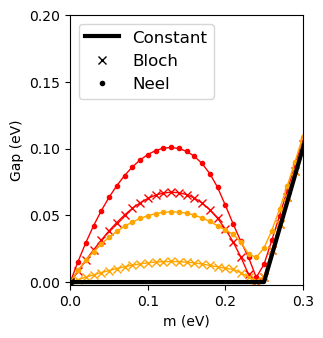

In [7]:
fig, axs = PyPlot.subplots(figsize=(3,3.5));
matplotlib[:rc]("font", size=12)
colors = ["red", "orange", "yellow", "green", "blue", "purple"]

axs.set_xlabel("m (eV)")
axs.set_ylabel("Gap (eV)")

axs.set_xlim([0.0, 0.3])
axs.set_ylim([-0.002, 0.2])

for nGh = 1:maxnGh
    PyPlot.plot(vals, blochPlots[nGh], marker="x", label = "", color = colors[nGh], lw=1.0)
    PyPlot.plot(vals, neelPlots[nGh], marker=".", label = "", color = colors[nGh], lw=1.0)
end
PyPlot.plot(vals, constgaps[1], label="Constant",  color = "black", lw=3)

PyPlot.plot([0.0],[0.0],marker="x",label="Bloch", color="black", lw=0)
PyPlot.plot([0.0],[0.0],marker=".",label="Neel", color="black", lw=0)
#PyPlot.plot([0,0.25,0.65],[0,0,0.40], label="Constant", color="black", lw=2)
#PyPlot.plot([0.0],[0.0],linestyle="dashdot",label="Const", color="black", lw=2)
PyPlot.legend(loc="upper left");
#PyPlot.savefig("/home/viv/Desktop/gap_sweep.png")
#gcf()

# ====================================================
# mostly unrelated stuff that is not pertinent at the exact moment:

In [ ]:
pygui(:qt)
function iplotMultiBands(klist, nk, EArrs, projStateArrs, labels=["","",""], name="", figsize=(10,8))
    fsize = 20
    matplotlib[:rc]("font", size=fsize)
	#Plots.pyplot()
	nSymPts = size(klist)[1]
	indices = LinRange(0,nSymPts-1, size(EArrs[1])[1])
	nE = size(EArrs[1])[2]
    nplots = size(EArrs)[1]
    println("size EArrs: $(size(EArrs)), size Earrs[1]: $(size(EArrs[1]))size projStateArrs: $(size(projStateArrs)), nplotes = $nplots")
    fig, axs = PyPlot.subplots(nrows=nplots, ncols=1, figsize=figsize);
	#display(E[:,1])
	#display(plot!(indices,E[1,:]))
	#display(plot!(indices,E[:,2]))
	#Eplot = transpose(E)
    kSymPts = [i for i =0:(nSymPts-1)]
    for iplot = 1:nplots
        ax = axs[iplot]
        E = EArrs[iplot]
        projStates = projStateArrs[iplot]
        println("size Evals: $(size(E)), size projStates: $(size(projStates))")
        for kTick in kSymPts
            ax.plot([kTick,kTick],[-30,30],c="black",lw=0.75)
            #ax.set_title(labels[iplot], (0.5, 0.45), ha="center", xycoords="axes fraction", size=fsize, c="black")
            #ax.set_yticks([])
            #ax.tick_params(labelcolor="none", which="both", top=false, bottom=false, left=false, right=false)
        end
        ax.set_xticks([])
        for iE = 1:nE
            Evals = collect(E[:,iE])
            # MEGA JANK THAT REALLY NEEDS FIXING WITH COLORBAR, USED TO MAKE AXS
            # COLORBAR CONSISTENT WITH DATA
            Projvals = (-1)*collect(projStates[:,iE])
            #println("size Evals: $(size(Evals)), size ProjVals: $(size(Projvals))")
            ax.scatter(indices,Evals,c=Projvals, cmap="coolwarm", s=0.08, vmin = -1.0, vmax = 1.0)
            #scatter(indices,Evals,c=Projvals, vmin=0, vmax=1,s=0.9)
            #display(plot!(indices,Evals))
        end
        #ax.set_ylabel("Energy (eV)")
        #ax.set_title(labels[iplot],size=fsize, c="black")
    end
    #axs[1].set_ylabel("Energy (eV)")
    PyPlot.xlim(0, nSymPts-1)
    maxE = 0.40
    #maxE = maximum(E)
    minE = -maxE
    #PyPlot.ylabel("Energy (eV)", fontsize=fsize)
    dE = 0.0
    PyPlot.ylim(minE-dE,maxE+dE)
    fig.tight_layout()
	PyPlot.xticks(kSymPts,klist, fontsize=fsize*0.75, horizontalalignment="center")
    plt.setp(axs, xlim=(0, nSymPts-1), ylim=(minE-dE,maxE+dE), ylabel="Energy (eV)")
    #plt.setp(axs, xlim=(0, nSymPts-1), ylim=(minE-dE,maxE+dE))
    #fig.supylabel("Energy (eV)")
	#=xlim(0, nSymPts-1)
    #maxE = minimum(abs.(E))
	#maxE = maximum(E)
	#minE = -maxE
	#ylabel("Energy (eV)", fontsize=fsize)
    #    dE = 0.4
	#ylim(minE-dE,maxE+dE)=#
    cmap = "coolwarm_r"; norm = PyPlot.matplotlib.colors.Normalize(vmin=-1, vmax=1)
	cbar = PyPlot.colorbar(PyPlot.cm.ScalarMappable(norm=norm, cmap=cmap),ax = axs, shrink=0.90, pad=0.025);
    #cbar = PyPlot.colorbar(label=name, titlesize=fsize);
    cbar.ax.set_title(name, loc="center", fontsize=fsize*1.2)
	gcf()
        #fig
end

In [ ]:
nx = 100; nGh = 20; nG = nGh*2+1; 
γ⁵ = σ[1]⊗I(2); S₂ = I(2)⊗σ₂; 
γᴸ= (1/2)*(I(4) .- γ⁵); γᴿ= (1/2)*(I(4) .+ γ⁵);
Q = I(nG)⊗γ⁵;
neigs = 4*2*p.arpack + nG*4*(p.arpack == false); nk = 40; maxE = 0.1; nkb = 2^9;

In [ ]:
Hsimple, p = Htype(nx,1,1,"consty",[nGh;0;0]);
Q = I(p.nG)⊗γ⁵;
Hn, p = Htype(nx,1,1,"sNeel",[nGh;0;0]);
Hb, p = Htype(nx,1,1,"sBloch",[nGh;0;0]);

In [ ]:
# Generate simple Weyl dispersion for Figure 1a  
# Should expect two cones, of blue and red corresponding to chirality
klist = ["[1/nx,0,0](π/a₀)","Γ","[0,1,0](π/a₀)", "Γ","[0,0,1](π/a₀)"]
Econsty, projvalsconsty = projGrBands(klist, kdictGen(p.A), nkb, a, Hsimple, Q, p.arpack);
En, projvalsn = projGrBands(klist, kdictGen(p.A), nkb, a, Hn, Q, p.arpack);
Eb, projvalsb = projGrBands(klist, kdictGen(p.A), nkb, a, Hb, Q, p.arpack);

In [ ]:
klist = ["[1/nx,0,0](π/a₀)","Γ","[0,1,0](π/a₀)", "Γ","[0,0,1](π/a₀)"]
Earray = [Econsty,En,Eb];
projValArray = [projvalsconsty,projvalsn,projvalsb];
#labels = ["Constant M: β = Jŷ", "Neel DWs: β = J(cos(θᵣ)ŷ+sin(θᵣ)x̂)", "Bloch DWs: β = J(cos(θᵣ)ŷ+sin(θᵣ)ẑ))"]
labels = ["Constant M: β = Jŷ", "Neel DW superlattice", "Bloch DW superlattice"]
fig = iplotMultiBands(klist,nkb,Earray, projValArray, labels, "⟨γ̂⁵⟩\n",(10,7.5));

In [ ]:
klist = ["k₀", "k₀+[1/nx,0,0](π/a₀)"]; β=0.25
Econsty_WP, projvalsconsty_WP = projGrBands(klist, kdictGen(p.A,β), nkb, a, Hsimple, Q, p.arpack);
En_WP, projvalsn_WP = projGrBands(klist, kdictGen(p.A,β), nkb, a, Hn, Q, p.arpack);
Eb_WP, projvalsb_WP = projGrBands(klist, kdictGen(p.A,β), nkb, a, Hb, Q, p.arpack);

In [ ]:
Earray = [Econsty_WP,En_WP,Eb_WP];
klist = ["k₀", "k₀+[1/nx,0,0](π/a₀)"];
projValArray = [projvalsconsty_WP,projvalsn_WP,projvalsb_WP];
#labels = ["Constant M: β = Jŷ", "Neel DWs: β = J(cos(θᵣ)ŷ+sin(θᵣ)x̂)", "Bloch DWs: β = J(cos(θᵣ)ŷ+sin(θᵣ)ẑ))"]
labels = ["Constant M: β = Jŷ", "Neel DW superlattice", "Bloch DW superlattice"]
fig = iplotMultiBands(klist,nkb,Earray, projValArray, labels, "⟨γ̂⁵⟩\n", (4,7));

In [ ]:
# for massive cases 
m = 0.0*eV
nx = 100; nGh = 20; nG = nGh*2+1; β = 0.25; 
Hsimple, p = Htype(nx,1,1,"consty",[nGh;0;0], β, m);
Hnm, p = Htype(nx,1,1,"sNeel",[nGh;0;0], β, m);
Hn, p = Htype(nx,1,1,"sNeel",[nGh;0;0], β, 0.0);
Hbm, p = Htype(nx,1,1,"sBloch",[nGh;0;0], β, m);
Hb, p = Htype(nx,1,1,"sBloch",[nGh;0;0], β, 0.0);
Q = I(p.nG)⊗γ⁵;
neigs = 4*p.nG; nk = 40; maxE = 1.1*(m + β);
#eigSurface(p,Hn,Q,neigs,"x",nk,nk,0.0,maxE);
#eigSurface(p,Hb,Q,neigs,"x",nk,nk,0.0,maxE);

In [ ]:
eigSurface(p,Hsimple,Q,neigs,"x",nk,nk,0.0,maxE);
#eigSurface(p,Hbm,Q,neigs,"x",nk,nk,0.0,maxE);
#eigSurface(p,Hb,Q,neigs,"x",nk,nk,0.0,maxE);

In [ ]:
#eigSurface(p,Hsimple,Q,neigs,"x",nk,nk,0.0,maxE);
#eigSurface(p,Hnm,Q,neigs,"x",nk,nk,0.0,maxE);
eigSurface(p,Hn,Q,neigs,"x",nk,nk,0.0,maxE);
#eigSurface(p,Hb,Q,neigs,"x",nk,nk,0.0,maxE);

In [ ]:
eigSurface(p,Hb,Q,neigs,"x",nk,nk,0.0,maxE)

In [ ]:
#display(Hn(0.0*[1,1,1]))
d = diag(Hn([1.0;1.0;1.0]))
display(d)
    #show(stdout, "text/plain", (Hn([1.0;1.0;1.0])))

In [ ]:
b = 0.5; v = 1; m = 0/2
function H_simple(k) 
    return v*τ₁⊗(k[1]*σ₁ .+ k[2]*σ₂ .+ k[3]*σ₃) .+ b*τ₀⊗σ₂ .+ m*τ₃⊗σ₀
end

k₀ = [0;1;0]*sqrt(b^2-m^2)/v

γ⁵ = τ₁⊗σ₀

function projGr(Q,k,E)
    Gʳ = inv((E+0.01*im)*I(4) .- H_simple(k))
    return (-1/π)*imag.(tr((Q*Gʳ)))/((-1/π)*imag.(tr((Gʳ))))
end

projGr(γ⁵,k₀,0)
Hkplus = H_simple(k₀)
E, Estates = eigen(Hkplus)
display(E)
display(Estates)
display(projGr(γ⁵,k₀,0))

In [ ]:
Estates; WPp = Estates[:,2]; 
WPp'*γ⁵*WPp

In [ ]:
#E, Estates = getBands(klist, kdictGen(p.A), nkb, a, Hsimple, p.arpack)
LprojStates = expectedValue(I(p.nG)⊗γᴸ ,Estates); RprojStates = expectedValue(I(p.nG)⊗γᴿ ,Estates)
Lfig = plotBands(klist,nk,E, LprojStates); Rfig = plotBands(klist,nk,E, RprojStates);
#display(Lfig); display(Rfig);

In [ ]:
# Generate Neel-flattened bands for Figure 1b
Hn, p = Htype(nx,1,1,"sNeel",[nGh;0;0])
eigSurface(p,Hn,Q,neigs,"x",nk,nk,0.0,maxE)
E, Estates = getBands(klist, kdictGen(p.A), nkb, a, Hn, p.arpack);
#γprojStates = expectedValue(I(p.nG)⊗γ⁵ ,Estates)
#fig = plotBands(klist,nk,E, γprojStates);

In [ ]:
LprojStates = expectedValue(I(p.nG)⊗γᴸ ,Estates); RprojStates = expectedValue(I(p.nG)⊗γᴿ ,Estates)
Lfig = plotBands(klist,nk,E, LprojStates); Rfig = plotBands(klist,nk,E, RprojStates);

In [ ]:
# Generate Bloch-flattened bands for Figure 1c
# Generate Neel-flattened bands for Figure 1b
Hb, p = Htype(nx,1,1,"sBloch",[nGh;0;0])
eigSurface(p,Hb,Q,neigs,"x",nk,nk,0.0,maxE)
E, Estates = getBands(klist, kdictGen(p.A), nkb, a, Hb, p.arpack)
γprojStates = expectedValue(I(p.nG)⊗γ⁵ ,Estates)
fig = plotBands(klist,nk,E, γprojStates);
B5 = 2*π*β/(nx*a*p.vf)
println("B₅ = $B5")
Nlls = addLLs(fig,B5,p.vf*1.0,3,0.0,true,true)
display(Nlls)

In [ ]:
println("Generating periodic field hamiltonian")
H = ConstructHamiltonian(p,[V,Mx,My,Mz])
#H = Hβgen(p,[Mx,My,Mz])

nk = 2^8
println("Getting eigenvalues of 2D weyl lattice between k = ")
show(klist)
println("...")




γ⁵ = σ[1]⊗I(2)
γᴸ= (1/2)*(I(4) .- γ⁵)
Q = I(p.nG)⊗γ⁵


E, Estates = getBands(klist, kdictGen(p.A), nk, a, H, p.arpack)
γprojStates = expectedValue(I(p.nG)⊗γ⁵ ,Estates)
fig = plotBands(klist,nk,E, γprojStates)

#Q = I(p.nG)⊗τ₀⊗(σ₂.+σ₃)/2;
#σprojStates = expectedValue(Q,Estates)
#plotBands(klist,nk,E, σprojStates)

nk = 40
#kslice(p,H,0.24,"x",nk,nk,1.0)
#energySurface(p,H,0.20,3,nk,nk)
neigs = 4*p.arpack + p.nG*p.norb*2*(!p.arpack)

#eigSurface(p,H,I(p.nG)⊗γᴸ,neigs,"x",nk,nk,0.5)
#eigSurface(p,H,Q,neigs,"x",nk,nk,0.0)

In [ ]:
#function addLLs(fig, B::Float64, vf::Float64=1.0*10^6, nLL::Int=3, Ef::Float64=0.0, vert=true, plot=fa)


B5 = 2*π*β/(nx*a*p.vf)
println("B₅ = $B5")
Nlls = addLLs(fig,B5,p.vf*1.0,3,0.0,true,true)
display(Nlls)

In [ ]:
function addLLs(fig, B::Float64, vf::Float64=1.5*10^6, nLL::Int=3, Ef::Float64=0.0, vert=true, plot=false)
	LLs = [sign(n)*√(2*q*ħ*abs(n)*B*vf^2)/q for n = -nLL:nLL]
	#LLs = [sign(n)*vf*√(2*q*ħ*abs(n)*B)/q for n = -nLL:nLL]
	println("Landau levels: ")
	show(LLs)
	println("\n")
	if(plot)
		figure(fig)
		if(vert)
			for n = 1:(2*nLL+1)
				LL = LLs[n]
				PyPlot.plot([0,10],[LL,LL],linewidth=0.5,c="red")
			end
		else
			for n = 1:(2*nLL+1)
				LL = LLs[n]
				PyPlot.plot([LL,LL],[0,0.05],linewidth=0.5,c="red")
			end
		end
	end
	gcf()
end

display(addLLs(fig,B5,p.vf*1.0))

In [ ]:
nx = 100

function neelβToH(β::Float64)
    p = paramGen(nx,1,1,[60,0,0])
    V = zeros(ComplexF64,p.sG[1],p.sG[2],p.sG[3])
    Mx = zeros(ComplexF64,p.sG[1],p.sG[2],p.sG[3])
    My = zeros(ComplexF64,p.sG[1],p.sG[2],p.sG[3])
    Mz = zeros(ComplexF64,p.sG[1],p.sG[2],p.sG[3])
    #β = 1.0
    My[gridOffset(p,[1,0,0])] = β/2; My[gridOffset(p,[-1,0,0])] = β*1/2
    Mx[gridOffset(p,[1,0,0])] = β*im/2; Mx[gridOffset(p,[-1,0,0])] = -β*im/2
    H = ConstructHamiltonian(p,[V,Mx,My,Mz])
    return H
end


function spectrumSweep(HGen::Function,xvals::Vector,kpt::Vector)
    xvalsplot = Float64[]; yvals = Float64[]
    BLAS.set_num_threads(8)
    for x in xvals
        #println("Sweeping exchange splitting = $x")
        H = HGen(x)
        eigens, eigvecs = eigs(H(kpt), nev=130, which=:SM)
        #eigens = eigvals(Array(H(kpt)))
        append!(yvals,real.(eigens))
        append!(xvalsplot,[x for i = 1:size(eigens)[1]])
    end
    return xvalsplot, yvals
end
   

function plotLLsSweep(HGen::Function, Jvals::Vector)
    Js, Energies = spectrumSweep(HGen, Jvals, 0.0*[0.0;0.0;0.0])
    fig = scatter(Js,Energies, label="Spectrum of H(Γ)", color = :black, markersize = 1.2)
    ylims!((-0.01,0.45))
    B₅vals = Jvals*2*π/(a*nx*p.vf)
    for nLL = 0:4      
        LLs = sqrt.(2*q*ħ*nLL*B₅vals*p.vf^2)/q
        if(nLL != 0)
            plot!(Jvals,LLs, color=:red, linewidth=0.5, label="")
        else
            plot!(Jvals,LLs, color=:red, linewidth=0.5, label="pseudo-landau levels", legend=:topleft)
        end
    end
    ylabel!("Energy (eV)"); xlabel!("Exchange splitting J (eV)")
    #[sign(n)*√(2*q*ħ*abs(n)*B*vf^2)/q for n = -nLL:nLL]
    display(fig)
end


Jvals = [J for J = 0.0:0.005:1.0]
#plotLLsSweep(neelβToH, Jvals)

#Jvals = [J for J = 0.0:0.01:0.5]
Js, Energies = spectrumSweep(neelβToH, Jvals, 0.0*[1;1;1])


#E, Estates = getBands(klist, kdictGen(p.A), nk, a, H, p.arpack)
#γprojStates = expectedValue(2*I(p.nG)⊗γ⁵ ,Estates)
#bands = plotBands(klist,nk,E, γprojStates, "⟨γ⁵⟩")
B5 = 2*π*β/(nx*a*p.vf)
println("B₅ = $B5")
#addLLs(bands,B5,p.vf*1.0,3,0.0,true,true)

In [ ]:
function annotatewithbox!(
		fig::Plots.Plot,
		text::Plots.PlotText,
		x::Real, y::Real, Δx::Real, Δy::Real = Δx;
		kwargs...)
	
	box = Plots.Shape(:rect)
	
	Plots.scale!(box, Δx, Δy)
	Plots.translate!(box, x, y)

	Plots.plot!(fig, box, c = :white, linestroke = :black, label = false; kwargs...)
	Plots.annotate!(fig, x, y, text)
	
	fig
end

fsize = 14

s(x) = x^2
lw = 1.0

fig = Plots.scatter(Js,s.(Energies), label="Spectrum of H(Γ)", color = :black, markersize = lw, thickness_scaling = 1.5)
    #ylims!((-0.0001,0.35))
    ylims!((-0.0001,s(0.9)))
    xlims!((0.001,0.95))
    B₅vals = Jvals*2*π/(a*nx*p.vf)
    plot!(size=(400,400))
    fig = plot!(Jvals,Jvals*0.0, color=:red, linewidth=lw, label="Axial Landau levels", legend=:topleft, legendfontsize=round(fsize*0.35,sigdigits=1))
    for nLL = 1:4      
        LLs = s.(sqrt.(2*q*ħ*nLL*B₅vals*p.vf^2)/q)
        plot!(Jvals,LLs, color=:red, linewidth=lw*1.5, label="")
    end
    sbs = :purple
    plot!([0,0.04],(0)^2*[1,1], color=sbs, linewidth=0.0, label="Non-magnetized subbands", fontsize=fsize*0.5)
    for nsB = 1:20
        plot!([0,0.08],s(nsB*p.vf*(ħ/q)*2*π/(a*nx))*[1,1], color=sbs, linewidth=1.5, label="")
    end
    plot!(Jvals,s.(Jvals), linewidth=3, label="J", 
                fillrange = -s.(Jvals), fillalpha = 0.2, c=1)
    ylabel!("E² (eV²)", fontsize=fsize); xlabel!("J (eV)", fontsize=fsize)
    str = "Inside Weyl cones"
    str0 = "█"^(length(str)÷2+1)
    #annotatewithbox!(fig, Plots.text(str, :blue2, :center, 12, "Helvetica Bold"), 0.75, 0.023,0.25,0.015)
    #annotatewithbox!(0.35, 0.03, text(str, :blue2, :center, 23, "Helvetica Bold"))
    #annotate!(0.35, 0.03, text(str0, :blue2, :center, 23, "Helvetica Bold"))
    
    #[sign(n)*√(2*q*ħ*abs(n)*B*vf^2)/q for n = -nLL:nLL]
    display(fig)
    Plots.savefig(fig, "~/Desktop/NeelLLs.png")